<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv3/Fine_tune_LayoutLMv3_on_FUNSD_(HuggingFace_Trainer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

First, we install 🤗 Transformers, as well as 🤗 Datasets and Seqeval (the latter is useful for evaluation metrics such as F1 on sequence labeling tasks).

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [ ]:
!pip install -q datasets seqeval

In [2]:
import ast
import glob
import json
import os
from io import BytesIO
from pathlib import Path
from typing import List
from urllib.parse import urlparse

import numpy as np
import pandas as pd
import requests
from PIL import Image
from lxml import etree
from pytesseract import pytesseract
from shapely.geometry import Polygon
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from docling_core.types.doc import ImageRefMode
from docling_core.types.doc.document import DocTagsDocument, DoclingDocument
from mlx_vlm import load, generate
from mlx_vlm.prompt_utils import apply_chat_template
from mlx_vlm.utils import load_config, stream_generate

from transformers import AutoProcessor

In [1]:


ROOT_DIR = Path(os.getcwd()).parent
SCHEMATISM_PATH = os.path.join(ROOT_DIR, "layoutLMv3/images")
# Load annotation file
with open(os.path.join(ROOT_DIR,"layoutLMv3/wloclawek_1872_dataset.json")) as f:
    dataset_annotations = json.load(f)


NameError: name 'Path' is not defined

In [ ]:
dataset_annotations

In [ ]:
# unique_labels = set()
# for record in dataset_annotations:
#     if "annotations" in record.keys():
#         for annotation in record["annotations"]:
#             for label in annotation["result"]:
#                 if "value" in label.keys():
#                     if label["value"]["rectanglelabels"][0] not in unique_labels:
#                         unique_labels.add(label["value"]["rectanglelabels"][0])
# unique_labels.remove("roi")
# print(f"Unique labels: {unique_labels}")

['B-page_number',
 'B-building_material',
 'B-settlement_classification',
 'B-parish',
 'B-building_type',
 'B-dedication',
 'B-deanery',
 'I-page_number',
 'I-building_material',
 'I-settlement_classification',
 'I-parish',
 'I-building_type',
 'I-dedication',
 'I-deanery',
 'O']

In [ ]:
labels = ['page_number', 'building_material', 'settlement_classification', 'parish', 'building_type', 'dedication', 'deanery']
bio_labels = ["B-{}".format(label) for label in labels] + ["I-{}".format(label) for label in labels] + ["O"]

label2id = {label: i for i, label in enumerate(bio_labels)}
id2label = {i: label for i, label in enumerate(bio_labels)}
id2label

{0: 'B-page_number',
 1: 'B-building_material',
 2: 'B-settlement_classification',
 3: 'B-parish',
 4: 'B-building_type',
 5: 'B-dedication',
 6: 'B-deanery',
 7: 'I-page_number',
 8: 'I-building_material',
 9: 'I-settlement_classification',
 10: 'I-parish',
 11: 'I-building_type',
 12: 'I-dedication',
 13: 'I-deanery',
 14: 'O'}

In [5]:
import os
from PIL import ImageDraw

# Set TOKENIZERS_PARALLELISM to either "true" or "false"
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # or "true"
os.environ["TESSDATA_PREFIX"] = "/opt/homebrew/share/tessdata/"

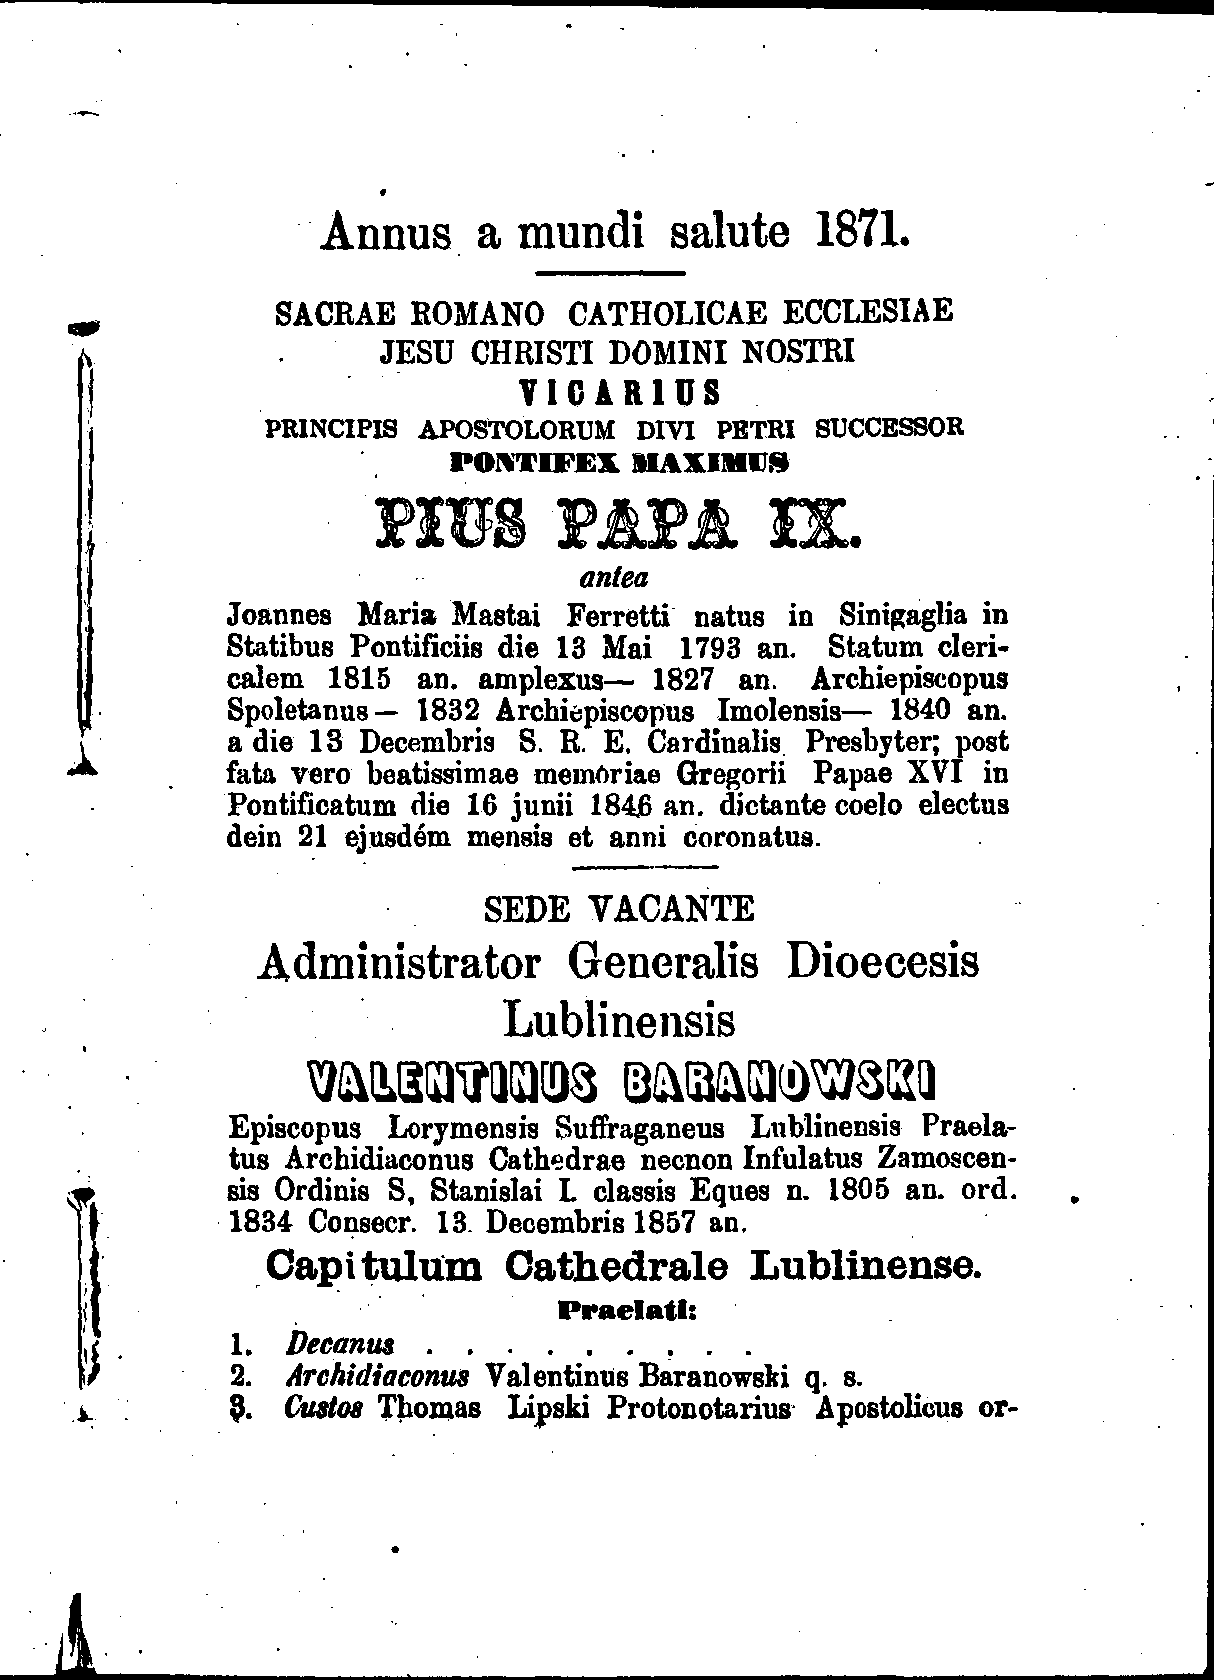

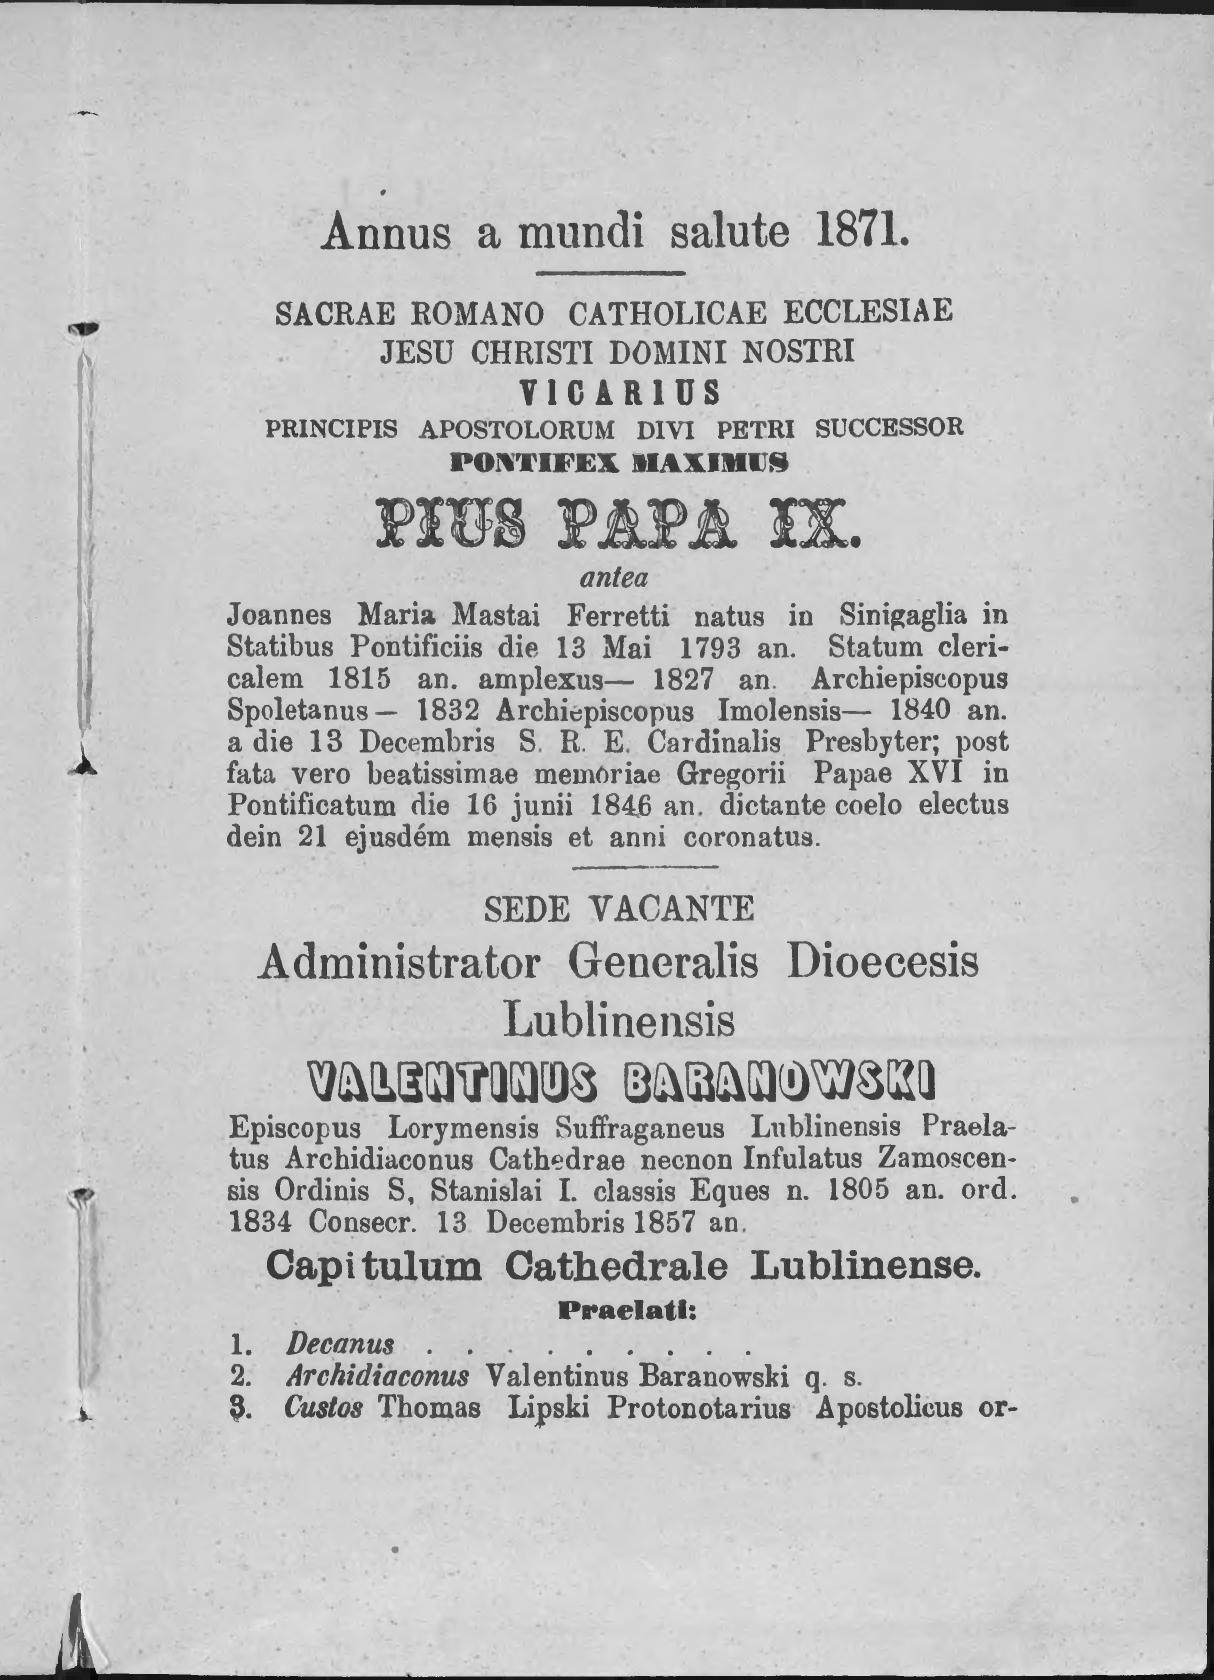

In [7]:
with Image.open("/Users/user/Projects/ecclesiasticalOCR/data/schematyzmy/lublin_1871/0005.jpg") as img:

    result = preprocess_for_ocr(img)
    display(result)
    display(img)

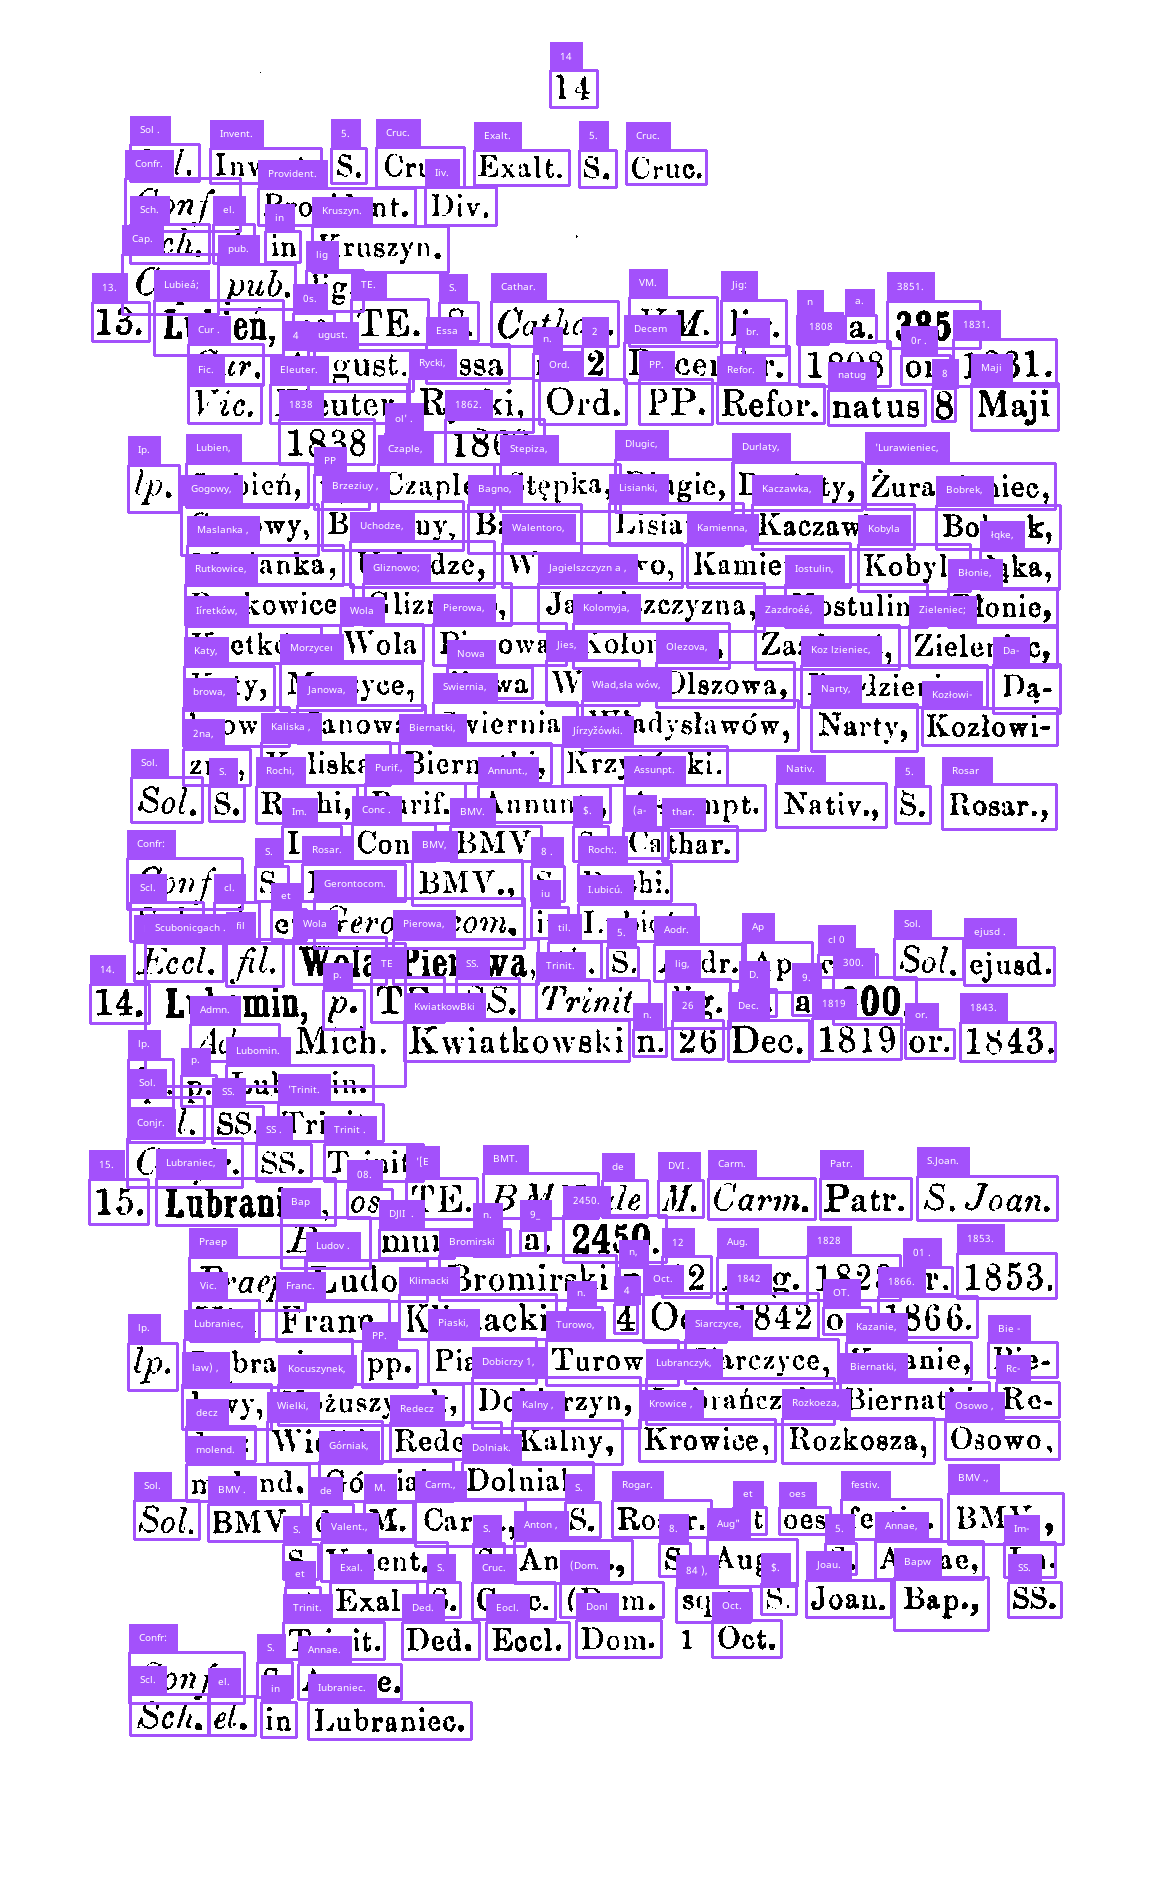

In [8]:
import easyocr
from PIL import Image, ImageDraw, ImageFont
import easyocr
import supervision as sv
import cv2
import numpy as np


reader = easyocr.Reader(["la"])
font = ImageFont.load_default()

image_path = os.path.join(SCHEMATISM_PATH, '0014.jpg')
with Image.open(image_path) as img:
    img = preprocess_for_ocr(img)
    image_for_drawing = img.convert("RGB").copy()
    draw = ImageDraw.Draw(image_for_drawing)

    output = reader.readtext(np.array(image_for_drawing),    
                            paragraph=False,
                            detail=1,
                            decoder='greedy',            # greedy działa najlepiej dla "liter po literze"
                            slope_ths=0.0,               # NIE łącz nawet lekko przekrzywionych znaków
                            ycenter_ths=0.0,             # NIE łącz znaków, które nie są idealnie na tej samej wysokości
                            height_ths=0.0,              # NIE łącz znaków o różnych wysokościach
                            width_ths=0.0,)

    xyxy, confidences, class_ids, label = [], [], [], []


    for detection in output:
        bbox, text, confidence = detection[0], detection[1], detection[2]
    
        # Convert bounding box format
        x_min = int(min([point[0] for point in bbox]))
        y_min = int(min([point[1] for point in bbox]))
        x_max = int(max([point[0] for point in bbox]))
        y_max = int(max([point[1] for point in bbox]))
    
        # Append data to lists
        xyxy.append([x_min, y_min, x_max, y_max])
        label.append(text)
        confidences.append(confidence)
        class_ids.append(0)  

    # Convert to NumPy arrays
    detections = sv.Detections(
        xyxy=np.array(xyxy),
        confidence=np.array(confidences),
        class_id=np.array(class_ids)
    )

    # Annotate image with bounding boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.RichLabelAnnotator(font_path="/Users/user/Projects/ecclesiasticalOCR/layoutLMv3/NotoSans-Regular.ttf")

    annotated_image = box_annotator.annotate(scene=image_for_drawing, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=label)

    # Display and save the annotated image
    #sv.plot_image(image=annotated_image)
    display(annotated_image)


In [ ]:
out = ""
for line in output:

    print(line[1],line[2])

In [9]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests
from transformers import logging
logging.set_verbosity_info()
# load image from the IAM database (actually this model is meant to be used on printed text)


ocr_processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-printed')
ocr_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-printed')


loading configuration file preprocessor_config.json from cache at /Users/user/.cache/huggingface/hub/models--microsoft--trocr-small-printed/snapshots/04e994ab854b0089d4929f48c2b4dbe2ce78a340/preprocessor_config.json
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
size should be a dictionary on of the following set of keys: ({'height', 'width'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}, {'longest_edge'}, {'max_height', 'max_width'}), got 384. Converted to {'height': 384, 'width': 384}.
crop_size should be a dictionary on of the following set of keys: ({'height', 'width'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}, {'longest_edge'}, {'max_height', 'max_width'}), got 224. Converted to {'height':

In [40]:
llmv3_processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-large", apply_ocr=True)

preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [10]:
def unnormalize_box(bbox, width, height, x_ratio: float, y_ratio: float):
    """
    Unnormalize the bounding box coordinates from the OCR model output
    to the original image dimensions and enlarge it by x_ratio / y_ratio.
    """
    # map from 0–1000 coords to absolute pixels
    x0 = width * bbox[0] / 1000
    y0 = height * bbox[1] / 1000
    x1 = width * bbox[2] / 1000
    y1 = height * bbox[3] / 1000

    # compute center and size
    cx = (x0 + x1) / 2
    cy = (y0 + y1) / 2
    w_box = x1 - x0
    h_box = y1 - y0

    # scale by ratios
    new_w = w_box * x_ratio
    new_h = h_box * y_ratio

    # rebuild around center, clamp to image bounds
    x0n = max(0, cx - new_w / 2)
    y0n = max(0, cy - new_h / 2)
    x1n = min(width,  cx + new_w / 2)
    y1n = min(height, cy + new_h / 2)

    return [int(x0n), int(y0n), int(x1n), int(y1n)]

In [11]:
def get_ocr_data(image, ocr_processor, ignored_tokens = None):
    # image_copy = image.convert("L")
        
    # if image_copy.mode != 'L':
    #     image_copy = image_copy.convert('L')
    # image_copy = preprocess_for_ocr(image_copy)
    # processed_image = preprocess_for_ocr(image_copy)
    # processed_image = processed_image.convert("RGB")



    encoding = ocr_processor(image, return_tensors="pt")
    extracted_tokens = ocr_processor.tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])
    extracted_bboxes = encoding["bbox"][0].tolist()
    
    # words = []
    # bboxes = []
    # current_word = ""
    # current_bbox = None

    # for i, (token, bbox) in enumerate(zip(extracted_tokens, extracted_bboxes)):
    #     normalized_bbox = unnormalize_box(bbox, image.width, image.height)

    #     if current_bbox is None:
    #         # First token - start a new word
    #         current_word = token
    #         current_bbox = bbox
    #     elif bbox == current_bbox:
    #         # Same bbox as the previous token - append to the current word
    #         current_word += "" + token  # Add space between tokens
    #     else:
    #         # Different bbox - end the current word and start a new one
    #         words.append(current_word)
    #         bboxes.append(current_bbox)  # Store the bounding box for the complete word
    #         current_word = token
    #         current_bbox = bbox

    # Add the last word if there is any
    # if current_word:
    #     words.append(current_word)
    #     bboxes.append(current_bbox)

    filtered_tokens = []
    filtered_bboxes = []

    for token, bbox in zip(extracted_tokens, extracted_bboxes):
        if not any([ignored_token in token for ignored_token in ignored_tokens]):

            filtered_tokens.append(token)
            filtered_bboxes.append(bbox)
        
    print(len(filtered_tokens), len(filtered_bboxes))
    return filtered_tokens, filtered_bboxes

In [12]:
def add_padding(image: Image, x_padding: int, y_padding: int) -> Image:
    """
    Add white padding around a PIL image with different horizontal and vertical padding values.

    Args:
        image (PIL.Image.Image): Input image
        x_padding (int): Amount of padding to add horizontally (left and right)
        y_padding (int): Amount of padding to add vertically (top and bottom)

    Returns:
        PIL.Image.Image: New image with padding
    """
    # Compute new dimensions
    new_width = image.width + (2 * x_padding)  # Add padding to both left and right
    new_height = image.height + (2 * y_padding)  # Add padding to both top and bottom

    # Create a new white image
    padded = Image.new(image.mode, (new_width, new_height), color="white")
    
    # Paste the original image in the center
    padded.paste(image, (x_padding, y_padding))
    
    return padded


In [15]:
def calculate_iou(box_1, box_2):
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    # print(poly_1,poly_2)
    # iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    iou = poly_1.intersection(poly_2).area
    min_area = min(poly_1.area,poly_2.area)
    return iou/min_area


def percent_to_bbox(x, y, w, h, img_w, img_h):
    x0 = int(x / 100 * img_w)
    y0 = int(y / 100 * img_h)
    x1 = int((x + w) / 100 * img_w)
    y1 = int((y + h) / 100 * img_h)
    return [x0, y0, x1, y1]

def bbox_to_1000(bbox, img_w, img_h):
    return [
        int(1000 * bbox[0] / img_w),
        int(1000 * bbox[1] / img_h),
        int(1000 * bbox[2] / img_w),
        int(1000 * bbox[3] / img_h),
    ]

def preprocess_ocr_data(ocr_output):
    processed_data = {
        "text": ocr_output["text"],
        "bbox": [
            [ocr_output["left"][i], ocr_output["top"][i], 
             ocr_output["left"][i] + ocr_output["width"][i], 
             ocr_output["top"][i] + ocr_output["height"][i]]
            for i in range(len(ocr_output["text"]))
        ],
    }
    return processed_data


In [ ]:
import os
import json
from PIL import Image, ImageDraw

def load_image(entry, schematism_path):
    image_file = entry["data"]["image"].split("-")[-1]
    image_path = os.path.join(schematism_path, image_file)
    print(f"Processing image: {image_path}")
    return Image.open(image_path).convert("RGB")

def process_annotations(annotations, image_width, image_height):
    processed = []
    for ann in annotations:
        if "value" not in ann:
            continue
        value = ann["value"]
        x = int(value["x"] / 100 * image_width)
        y = int(value["y"] / 100 * image_height)
        w = int(value["width"] / 100 * image_width)
        h = int(value["height"] / 100 * image_height)
        
        processed.append({
            "bbox": [[x, y], [x + w, y], [x + w, y + h], [x, y + h]],
            "entity": value["rectanglelabels"][0]
        })
    return processed

def match_bboxes(ocr_bbox, annotation_bboxes):
    for annotation in annotation_bboxes:
        if calculate_iou(bbox_to_polygon(annotation["bbox"]), ocr_bbox) >= 0.7:
            return annotation["entity"]
    return None

def get_bio_tag(current_entity, prev_entity):
    if not current_entity:
        return "O", None
    if current_entity != prev_entity:
        return f"B-{current_entity}", current_entity
    return f"I-{current_entity}", current_entity

def display_bbox_patch(image, bbox, text, label):
    cropped = image.crop((
        bbox[0][0], bbox[0][1], 
        bbox[2][0], bbox[2][1]
    ))
    padded = add_padding(cropped, 10, 5)
    display(padded)  # Requires Jupyter/IPython
    print(f"Text: {text}\nEntity: {label}\n{'='*30}")

def bbox_to_polygon(bbox):
    return [
        [bbox[0][0], bbox[0][1]],
        [bbox[1][0], bbox[1][1]],
        [bbox[2][0], bbox[2][1]],
        [bbox[3][0], bbox[3][1]]
    ]


# Main processing loop
dataset = []
print("Starting main processing loop...")

for entry in dataset_annotations[10:12]:
    print(f"\nProcessing entry ID: {entry['id']}")
    image = load_image(entry, SCHEMATISM_PATH)
    image_width, image_height = image.size
    print(f"Image size: {image_width}x{image_height}")
    draw = ImageDraw.Draw(image)
    
    # Get OCR data
    print("Performing OCR...")
    tokens, ocr_bboxes = get_ocr_data(image, llmv3_processor, ignored_tokens=["<s>", "</s>"])
    print(f"Found {len(tokens)} tokens")
    
    annotations = process_annotations(
        entry["annotations"][0]["result"], 
        image_width, 
        image_height
    )
    print(f"Processed {len(annotations)} annotations")
    
    entry_data = {
        "tokens": [],
        "bboxes": [],
        "ner_tags": [],
        "image_path": entry["data"]["image"],
        "id": entry["id"]
    }
    
    prev_entity = None
    print("\nProcessing tokens and matching with annotations...")
    for i, (token, bbox) in enumerate(zip(tokens, ocr_bboxes)):
        # Unnormalize OCR bbox
        bbox = unnormalize_box(bbox, image_width, image_height, x_ratio=1.3, y_ratio=1)
        
        entity = match_bboxes(bbox, annotations)
        if entity:
            print(f"Token '{token}' matched with entity '{entity}'")
    
        # Determine BIO tagging
        label, prev_entity = get_bio_tag(entity, prev_entity)
        
        # Store data
        entry_data["tokens"].append(token)
        entry_data["bboxes"].append(bbox)
        entry_data["ner_tags"].append(label2id[label])
        
        # Display matched entities
        display_bbox_patch(image, bbox, token, label)
    
    dataset.append(entry_data)
    print(f"Completed processing entry {entry['id']}")

print("\nSaving final dataset...")
with open("layoutlmv3_bio_dataset_v2.json", "w") as f:
    json.dump(dataset, f, indent=2)
print("Processing complete!")


Starting main processing loop...

Processing entry ID: 11
Processing image: /Users/user/Projects/ecclesiasticalOCR/layoutLMv3/images/0011.jpg
Image size: 1150x1900
Performing OCR...
839 839
Found 839 tokens
Processed 21 annotations

Processing tokens and matching with annotations...


TypeError: 'int' object is not iterable

In [ ]:
dataset_json = json.load(open("layoutlmv3_bio_dataset_v2.json"))
len(dataset_json)

In [ ]:
train, test = train_test_split(dataset_json, random_state=21, test_size=0.3)
print(f"Train size: {len(train)}, Test size: {len(test)}")

In [ ]:

for detail in dataset_json:
    with open('final_list_text.txt', 'a') as f:
        f.write(str(detail))
        f.write('\n')
        
for detail  in train:
    with open('images/train.txt', 'a') as f:
        f.write(str(detail))
        f.write('\n')
        
for detail  in test:
    with open('images/test.txt', 'a') as f:
        f.write(str(detail))
        f.write('\n')

## Load dataset

Next, we load a dataset from the 🤗 [hub](https://huggingface.co/datasets/nielsr/funsd-layoutlmv3). This one is the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset, a collection of annotated forms.

In [13]:
from datasets import load_dataset 

# this dataset uses the new Image feature :)
dataset = load_dataset("./dataset_loader.py")

In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 336
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 148
    })
})

As we can see, the dataset consists of 2 splits ("train" and "test"), and each example contains a list of words ("tokens") with corresponding boxes ("bboxes"), and the words are tagged ("ner_tags"). Each example also include the original image ("image").

Let's check the features:

In [ ]:
dataset["train"].features

Note that you can directly see the example in a notebook (as the "image" column is of type [Image](https://huggingface.co/docs/datasets/v2.2.1/en/package_reference/main_classes#datasets.Image)).

In [42]:
example = dataset["train"][0]
image = [example["image"]]

In [43]:
words, boxes, ner_tags = example["tokens"], example["bboxes"], example["ner_tags"]
print(words)
print(boxes)
print([id2label[i] for i in ner_tags])
print(ner_tags)

['66', 'Solem.', '8.', 'Joseph.', 'S.', 'Stanisl.', 'Confrat.', 'S.', 'Joseph.', '19.', 'Naramice,', 'p.', 'TE.', 'S.', 'Roch.', 'lig.', 'n.', 'a.', '750.', 'Adm,', 'Stanisl.', 'Zaleski', 'n.', '10', 'Jan.', '1826', 'or.', '1849,', 'lp.', 'p.', 'Naramnice.', 'Solem.', '8.', 'Rochi,', 'OO.', 'SS.,', 'Ded.', 'Eccl.', 'Dom.', '4', 'pt', 'Pasch.', 'Confrat.', '20.', 'Ossyjakéw,', 'os.', 'TE.', 'S.', 'Hedvig,', 'mur.', 'n.', 'a.', '5026.', 'Cur.', 'Jos.', 'Gorski', 'n.', '12', 'Mart.', '1794', 'or,', '1838.', 'Vie.', 'Domin.', 'Kochanowski', 'Ord.', 'S,', 'Pauli', 'n.', '16', 'Jan.', '1819', 'or.', '1345.', 'Ip.', 'Ossyjakéw,', 'pp.', 'Radoszewice,', 'Debina,', 'Felindw,', 'Gabryeldw,', 'Borkowe', 'molend,', 'Katerpole,', 'Zmyslona,', 'Bugaj,', 'Mierzas', 'now,', 'Szewezyki', 'deser.,', 'Kuénica', 'Lagowska,', 'Kuszyna,', 'Da-', 'browki,', 'Kuénica', 'Strobiska,', 'Chorzyna,', 'Krzetle,', '|', 'hiclin,', 'Strobin,', 'Walkéw,', 'Bebndéw,', 'Szynkieléw,', 'Dymek,', 'Czernice,', 'Huta', 'Szkla

## Prepare dataset

Next, we prepare the dataset for the model. This can be done very easily using `LayoutLMv3Processor`, which internally wraps a `LayoutLMv3FeatureExtractor` (for the image modality) and a `LayoutLMv3Tokenizer` (for the text modality) into one.

Basically, the processor does the following internally:
* the feature extractor is used to resize + normalize each document image into `pixel_values`
* the tokenizer is used to turn the words, boxes and NER tags into token-level `input_ids`, `attention_mask` and `labels`.

The processor simply returns a dictionary that contains all these keys.

In [ ]:


processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-large", apply_ocr=False)

encoding = processor(image, words, boxes=boxes, word_labels=ner_tags, truncation=True, stride =128, 
         padding="max_length", max_length=512, return_overflowing_tokens=True, return_offsets_mapping=True)

offset_mapping = encoding.pop('offset_mapping')

overflow_to_sample_mapping = encoding.pop('overflow_to_sample_mapping')

In [18]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    f_id2label = {k: v for k,v in enumerate(label_list)}
    f_label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    f_id2label = {k: v for k,v in enumerate(label_list)}
    f_label2id = {v: k for k,v in enumerate(label_list)}

f_label2id

{'B-page_number': 0,
 'B-building_material': 1,
 'B-settlement_classification': 2,
 'B-parish': 3,
 'B-building_type': 4,
 'B-dedication': 5,
 'B-deanery': 6,
 'I-page_number': 7,
 'I-building_material': 8,
 'I-settlement_classification': 9,
 'I-parish': 10,
 'I-building_type': 11,
 'I-dedication': 12,
 'I-deanery': 13,
 'O': 14}

Next, we'll define a function which we can apply on the entire dataset.

In [45]:
def prepare_examples(examples):
  images = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]
  encoding = processor(images, words, boxes=boxes, word_labels=word_labels, truncation=True, stride =128, 
         padding="max_length", max_length=512, return_overflowing_tokens=True, return_offsets_mapping=True)  
  offset_mapping = encoding.pop('offset_mapping')
  overflow_to_sample_mapping = encoding.pop('overflow_to_sample_mapping')
  return encoding

In [46]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly

features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
    # Optional: Add overflow mapping if needed later, though popped in prepare_examples
    # 'overflow_to_sample_mapping': Sequence(Value(dtype='int64')),
})
# ...existing code...

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/336 [00:00<?, ? examples/s]

Map:   0%|          | 0/148 [00:00<?, ? examples/s]

In [47]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 284
})

In [48]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> 66 Solem. 8. Joseph. S. Stanisl. Confrat. S. Joseph. 19. Naramice, p. TE. S. Roch. lig. n. a. 750. Adm, Stanisl. Zaleski n. 10 Jan. 1826 or. 1849, lp. p. Naramnice. Solem. 8. Rochi, OO. SS., Ded. Eccl. Dom. 4 pt Pasch. Confrat. 20. Ossyjakéw, os. TE. S. Hedvig, mur. n. a. 5026. Cur. Jos. Gorski n. 12 Mart. 1794 or, 1838. Vie. Domin. Kochanowski Ord. S, Pauli n. 16 Jan. 1819 or. 1345. Ip. Ossyjakéw, pp. Radoszewice, Debina, Felindw, Gabryeldw, Borkowe molend, Katerpole, Zmyslona, Bugaj, Mierzas now, Szewezyki deser., Kuénica Lagowska, Kuszyna, Da- browki, Kuénica Strobiska, Chorzyna, Krzetle, | hiclin, Strobin, Walkéw, Bebndéw, Szynkieléw, Dymek, Czernice, Huta Szklana, Piskornik deser., Jézefina, Nowa Wied, Folwark Raducki, Raduczyce, Bronistawéw, Szyszkowe, Drobnice. Solem, 8. Hedvig ct oes festiy, BMV. Confrat, S. Rosarii BMY. Capella mur. in Raudoszewice et Czernice. 21. Ozaréw, p. LE. S. Mur. Magd. ‘Vig. n. a, 2138. Adm. Ant. Szlenkiewiez n. 138 Jun. 1841 or. 1864, lp. pp. Oza

Next, we set the format to PyTorch.

In [49]:
train_dataset.set_format("torch")

Let's verify that everything was created properly:

In [50]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [51]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 284
})

In [52]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

'<s> 92 Sol. S. Jacob. Ap., 8. Barb,, Ded. Eccl. Dom. pt Exalt. S. Crue. Confr. Misericord. Xti. Schol. elem. in Dabrowa. Ptochotrophium in Dabrowsa, Cap. pub. mur S, Joach. in Coemet, cum Sol, ejusd. Sét. 9. Dmenin, p. TE. SS. Simon. et Jud. Ap. mur. n. a. 1785 Adm, Ign, Larecki un. 24 Dee. 1810 or. 1835. lp. pp. Dmenin, Goslawice, Kuénica, Lagiewniki, Smotry- szew, Lowicz, Brzezinki, Posadowka, Dziepute. Solem. VIL Dolor. BM., SS. Trinit., S, Laurent. (Dom. sq.), SS. Sim, et Jud. Ap. Confrat, SS. Trinit. Schota elem, in Dmenin, in Gostawice. Cap. pub. lig. S, Leonard. in Lagiewniki, cum Sol. F. 2 Pasch., Transf, D. S. Leonard. (6 Novemb.) 10. Dobryszyce, p. TE. S. Burthol. Ap, mur. n. a. 1452. Adm, Adalb. Kaszynski n. 24 Mart. 1819 or. 1542. Ip. pp. Dobryszyce, Zalesiezki, Folwark Malutki, Kolonia Rudzka, Kol. Borowa, Lefranédw, MKarkoszki, Zarki, Bo- rowiecko, Ruda, Zaby, Kmiecizna, Kotlewy, molend. Wo- jes, Zalesiczki, Mtyn. Sol. S Barthol, Ap. Con fr. S. Rosar. BMV. Schol. elem, i

In [53]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 66 0
 So 14
lem -100
. -100
 8 14
. -100
 Joseph 14
. -100
 S 14
. -100
 Stan 14
isl -100
. -100
 Conf 14
rat -100
. -100
 S 14
. -100
 Joseph 14
. -100
 19 3
. -100
 Nar 10
am -100
ice -100
, -100
 p 2
. -100
 TE 4
. -100
 S 5
. -100
 R 12
och -100
. -100
 lig 1
. -100
 n 14
. -100
 a 14
. -100
 750 14
. -100
 Ad 14
m -100
, -100
 Stan 14
isl -100
. -100
 Z 14
ales -100
ki -100
 n 14
. -100
 10 14
 Jan 14
. -100
 18 14
26 -100
 or 14
. -100
 18 14
49 -100
, -100
 l 14
p -100
. -100
 p 14
. -100
 Nar 14
amn -100
ice -100
. -100
 So 14
lem -100
. -100
 8 14
. -100
 R 14
och -100
i -100
, -100
 O 14
O -100
. -100
 SS 14
., -100
 Ded 14
. -100
 Ecc 14
l -100
. -100
 Dom 14
. -100
 4 14
 pt 14
 Pas 14
ch -100
. -100
 Conf 14
rat -100
. -100
 20 3
. -100
 Oss 10
y -100
j -100
ak -100
é -100
w -100
, -100
 os 2
. -100
 TE 4
. -100
 S 5
. -100
 Hed 12
v -100
ig -100
, -100
 mur 1
. -100
 n 14
. -100
 a 14
. -100
 50 14
26 -100
. -100
 Cur 14
. -100
 Jos 14
. -100
 Gors 14
ki -100
 n

## Define metrics

Next, we define a `compute_metrics` function, which is used by the Trainer to ... compute metrics.

This function should take a named tuple as input, and return a dictionary as output as stated in the [docs](https://huggingface.co/docs/transformers/main_classes/trainer).

In [54]:
import evaluate
# from datasets import load_metric
metric = evaluate.load("seqeval")

#metric = datasets.load_metric("seqeval")

In [ ]:
import numpy as np
import evaluate
# from datasets import load_metric
metric = evaluate.load("seqeval")
return_entity_level_metrics = True

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

## Define the model

Next we define the model: this is a Transformer encoder with pre-trained weights, and a randomly initialized head on top for token classification.

In [63]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-large",
                                                         id2label=id2label,
                                                         label2id=label2id)

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define TrainingArguments + Trainer

Next we define the `TrainingArguments`, which define all hyperparameters related to training. Note that there is a huge amount of parameters to tweak, check the [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) for more info.

We can now instantiate a Trainer, with the model and args defined above. We also provide our datasets, as well as a "default data collator" - which will batch the examples using `torch.stack`. We also provide our `compute_metrics` function defined above.

In [64]:
id2label

{0: 'B-page_number',
 1: 'B-building_material',
 2: 'B-settlement_classification',
 3: 'B-parish',
 4: 'B-building_type',
 5: 'B-dedication',
 6: 'B-deanery',
 7: 'I-page_number',
 8: 'I-building_material',
 9: 'I-settlement_classification',
 10: 'I-parish',
 11: 'I-building_type',
 12: 'I-dedication',
 13: 'I-deanery',
 14: 'O'}

In [76]:
labels = []
for example in dataset["train"]:
    labels += example["ner_tags"]

len(labels)

83596

In [77]:
labels

[0,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 3,
 10,
 2,
 4,
 5,
 12,
 1,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 3,
 10,
 2,
 4,
 5,
 12,
 1,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 3,
 10,
 2,
 4,
 5,
 12,
 12,
 1,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 3,
 10,
 2,
 4,
 5,
 12,
 12,
 1,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 

In [117]:
from collections import Counter
import math, torch

counts = Counter(labels)           # labels = pełna lista id‑ów (bez -100)
N = sum(counts.values())

def inv_sqrt_freq(cnt):            # √N / √nᵢ
    return math.sqrt(N / cnt)

num_labels = model.config.num_labels
weights = torch.ones(num_labels)

for lab_id, cnt in counts.items():
    weights[lab_id] = inv_sqrt_freq(cnt)

# O = id 0 → daj 1.0 lub 0.8
weights[0] = 0.8

# normalizacja
weights = weights / weights.mean()
weights = torch.clamp(weights, max=8.0)      # sufit 8 – zwykle wystarcza

print(weights)   

tensor([0.0313, 0.3964, 0.3817, 0.3733, 0.3817, 0.3861, 1.7902, 0.0392, 5.6612,
        2.3112, 0.3654, 0.7927, 0.2584, 1.7902, 0.0411])


In [ ]:
# from transformers.data.data_collator import default_data_collator
# import torch
# from transformers import Trainer
# from torch import nn
# from transformers import TrainingArguments, Trainer
# from transformers import DataCollatorForTokenClassification

# # Assuming processor, model, train_dataset, eval_dataset, compute_metrics,
# # id2label, class_weights are defined earlier in the notebook

# training_args = TrainingArguments(output_dir="test",
#                                   max_steps=400,
#                                   per_device_train_batch_size=2,
#                                   per_device_eval_batch_size=2,
#                                   learning_rate=5e-5,
#                                   eval_strategy="steps",
#                                   eval_steps=100,
#                                   load_best_model_at_end=True,
#                                   metric_for_best_model="eval_overall_f1",
#                                   report_to="tensorboard",
#                                   logging_strategy="steps",
#                                   logging_steps=50,
#                                   logging_dir="logs",
#                                   )

# class WeightedClassTrainer(Trainer):
#     def __init__(self, class_weights, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.class_weights = class_weights

#     def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
#         labels = inputs.pop("labels")
#         outputs = model(**inputs)
#         logits = outputs.logits

#         # Move class weights to the same device as logits
#         class_weights = self.class_weights.to(logits.device)

#         loss_fct = nn.CrossEntropyLoss(weight=class_weights)
#         loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
#         return (loss, outputs) if return_outputs else loss

# #map weights to labels


# trainer = WeightedClassTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset,
#     processing_class=processor, # Note: This argument might be incorrect, Trainer usually doesn't take processing_class
#     data_collator=default_data_collator,  # Use the fixed collator
#     compute_metrics=compute_metrics,
#     class_weights=weights,  # Use the tensor, not the dict

# )

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

# FocalLoss Trainer

In [123]:
from transformers import TrainingArguments, Trainer
from transformers.data.data_collator import default_data_collator
from torch import nn


import torch
import torch.nn as nn
import torch.nn.functional as F # Often useful, though not strictly needed for your current version

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'): # Added reduction parameter
        super().__init__()
        # alpha can be a scalar or a tensor of weights per class
        self.alpha = alpha
        self.gamma = gamma
        # reduction can be 'mean', 'sum', or 'none'
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: Logits (N, C)
        # targets: Ground truth labels (N)

        # Calculate Cross Entropy loss without reduction
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', ignore_index=-100)

        # Calculate pt (probability of the true class)
        pt = torch.exp(-ce_loss)

        # Calculate Focal Loss
        focal_term = (1 - pt) ** self.gamma
        loss = focal_term * ce_loss

        # Apply alpha weighting
        if isinstance(self.alpha, torch.Tensor):
            # Ensure alpha is on the same device and apply per-class weight
            alpha_t = self.alpha.to(inputs.device)[targets]
            loss = alpha_t * loss
        elif isinstance(self.alpha, (int, float)) and self.alpha != 1:
             # Apply scalar alpha
            loss = self.alpha * loss

        # Apply reduction
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else: # 'none'
            return loss

class FocalLossTrainer(Trainer):
    def __init__(self, *args, focal_loss_alpha=1, focal_loss_gamma=2, **kwargs):
        super().__init__(*args, **kwargs)
        # You can pass alpha/gamma during Trainer instantiation
        # If you want per-class alpha, pass the weight tensor here
        self.focal_loss = FocalLoss(alpha=focal_loss_alpha, gamma=focal_loss_gamma)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Extract labels
        labels = inputs.pop("labels")

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits



        # Simpler approach: Let FocalLoss compute on all, rely on large number of tokens
        # More correct: Filter ignored indices
        active_loss = labels.view(-1) != -100
        active_logits = logits.view(-1, self.model.config.num_labels)[active_loss]
        active_labels = labels.view(-1)[active_loss]

        if active_labels.numel() == 0: # Handle cases with no valid labels in batch
             loss = torch.tensor(0.0, device=logits.device, requires_grad=True)
        else:
             loss = self.focal_loss(active_logits, active_labels)


        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir="test_focal",
    max_steps=400,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=5e-5,
    eval_strategy="steps",         # ✅
    eval_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="overall_f1",   # ✅
    report_to="tensorboard",
    logging_strategy="steps",
    logging_steps=50,
    logging_dir="logs_focal",
)

# --- Option A: Using scalar alpha (like your original FocalLoss) ---
focal_trainer = FocalLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
    focal_loss_alpha=1,   # ← wagowy tensor
    focal_loss_gamma=2
)


## Train the model

Let's train!

In [125]:
focal_trainer.train()

/opt/anaconda3/envs/ocr/lib/python3.12/site-packages/transformers/modeling_utils.py:1558: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


TrainOutput(global_step=400, training_loss=0.0039130632625892755, metrics={'train_runtime': 1465.6611, 'train_samples_per_second': 0.546, 'train_steps_per_second': 0.273, 'total_flos': 748027731148800.0, 'train_loss': 0.0039130632625892755, 'epoch': 1.25})

In [122]:
# save stored trainer checkpoints
focal_trainer.save_model("checkpoints/checkpoint-400-steps")

In [70]:


trainer.train()

/opt/anaconda3/envs/ocr/lib/python3.12/site-packages/transformers/modeling_utils.py:1558: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


KeyboardInterrupt: 

## Evaluate the model

NOTE: we end up with an F1 score of about 90%. Here's what I got on a typical run:
```
Step	Training Loss	Val Loss	Precision	Recall	F1	Accuracy
100	  No log	  0.716025	0.752040	0.824143	0.786442	0.780459
200	  No log	  0.584986	0.828558	0.876304	0.851762	0.801973
300	  No log	  0.525926	0.859583	0.900149	0.879398	0.833947
400	  No log	  0.492821	0.881413	0.904620	0.892866	0.854630
500	  0.561200	0.528126	0.858382	0.885246	0.871607	0.852490
600	  0.561200	0.547107	0.888023	0.906110	0.896976	0.847973
700	  0.561200	0.555438	0.887338	0.915549	0.901222	0.859384
800	  0.561200	0.582942	0.881471	0.905117	0.893137	0.854749
900	  0.561200	0.599762	0.891051	0.910084	0.900467	0.852015
1000	0.133400	0.608207	0.887222	0.910581	0.898750	0.847855
````

However, this score cannot be directly compared to LayoutLM and LayoutLMv2, as LayoutLMv3 employs so-called **segment position embeddings** (inspired by [StructuralLM](https://arxiv.org/abs/2105.11210)). This means that several tokens that belong to the same "segment" (let's say, an address) get the same bounding box coordinates, and in return the same 2D position embeddings.

This is also mentioned in the paper:
>  Note that LayoutLMv3 and StructuralLM use segment-level layout positions, while the other works use word-level layout positions. The use of segment-level positions may benefit the semantic entity labeling task on FUNSD [25], so the two types of work are not directly comparable.

In [ ]:
trainer.evaluate()

/opt/anaconda3/envs/ocr/lib/python3.12/site-packages/transformers/modeling_utils.py:1558: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'eval_loss': 0.10444975644350052,
 'eval_building_material_precision': 1.0,
 'eval_building_material_recall': 0.9703703703703703,
 'eval_building_material_f1': 0.9849624060150376,
 'eval_building_material_number': 540,
 'eval_building_type_precision': 0.9851851851851852,
 'eval_building_type_recall': 0.9851851851851852,
 'eval_building_type_f1': 0.9851851851851852,
 'eval_building_type_number': 540,
 'eval_deanery_precision': 0.6666666666666666,
 'eval_deanery_recall': 1.0,
 'eval_deanery_f1': 0.8,
 'eval_deanery_number': 8,
 'eval_dedication_precision': 0.9558823529411765,
 'eval_dedication_recall': 0.9701492537313433,
 'eval_dedication_f1': 0.962962962962963,
 'eval_dedication_number': 536,
 'eval_page_number_precision': 0.9696969696969697,
 'eval_page_number_recall': 0.9696969696969697,
 'eval_page_number_f1': 0.9696969696969697,
 'eval_page_number_number': 132,
 'eval_parish_precision': 0.950354609929078,
 'eval_parish_recall': 0.9571428571428572,
 'eval_parish_f1': 0.953736654804